In [2]:
#import all libraries used in this notebook

#un-comment the next line if necessary
#!pip install tensorflow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as rn50_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as incept_preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xcept_preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
###Some constants 

#set image size
img_size = 80

#set batch size and seed
batch_size = 64
seed = 42

#reading the training input from directory
train_path = 'Data/train/*/*.png' 
files = glob(train_path)

In [4]:
###Some general operation and EDA before building the model

train_img = []
train_label = []

#read image files and set labels = folder names
for img in files:
    train_img.append(cv2.resize(cv2.imread(img), (img_size, img_size)))  #resize and append
    train_label.append(os.path.split(os.path.dirname(img))[-1])  # Get image label (folder name)

train_img = np.asarray(train_img)  # Train images set
train_label = pd.DataFrame(train_label)  # Train labels set

print(train_img.shape)
print(train_label.shape)

(4750, 80, 80, 3)
(4750, 1)


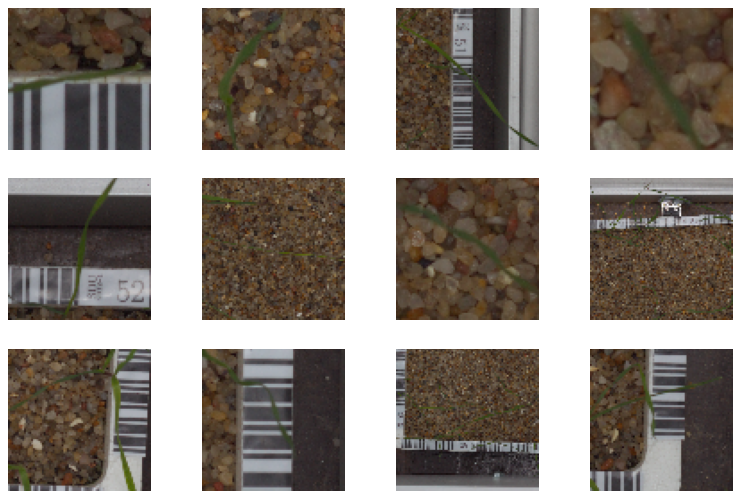

In [5]:
plt.figure(figsize = (12,8), dpi = 80)
#visulizing the first few images in the dataset
for i in range(12):
    plt.subplot(3, 4, i + 1)
    #cv2 read in BGR, show as in RGB
    plt.imshow(cv2.cvtColor(train_img[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.savefig('TrainImagesSample.png', bbox = 'tight')

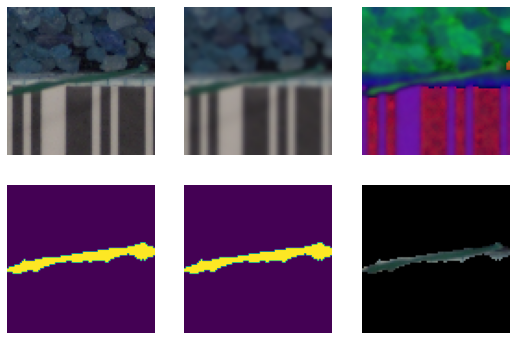

In [6]:
#Create masks for performance comparison

masked_train_img = []
#mask every img in train_img and store in masked_train_img
show_example = True
for img in train_img:
    #Gaussian blur
    blur_img = cv2.GaussianBlur(img, (5, 5), 0)   
    
    #HSV mask
    hsv_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)   
    lower_green = (25, 30, 40)
    upper_green = (85, 255, 255)
    mask = cv2.inRange(hsv_img, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    #Boolean mask
    boo_mask = mask > 0  
    
    #Apply mask
    tmp = np.zeros_like(img, np.uint8)  #Empty image
    tmp[boo_mask] = img[boo_mask]  
    
    masked_train_img.append(tmp)  
    
    #Show first masked image
    if show_example:
        plt.figure(figsize = (9, 6))
        plt.subplot(2, 3, 1)
        plt.axis('off')
        plt.imshow(img)  #original image
        plt.subplot(2, 3, 2)
        plt.axis('off')
        plt.imshow(blur_img)  #G-Blurred image
        plt.subplot(2, 3, 3)
        plt.axis('off')
        plt.imshow(hsv_img)  #image in HSV
        plt.subplot(2, 3, 4)
        plt.axis('off')
        plt.imshow(mask)  #mask image
        plt.subplot(2, 3, 5)
        plt.axis('off')
        plt.imshow(boo_mask)  #boolean mask
        plt.subplot(2, 3, 6)
        plt.axis('off')
        plt.imshow(tmp)  #masked image
        plt.savefig('ImageAndMask.png', bbox = 'tight')
        show_example = False

masked_train_img = np.asarray(masked_train_img)

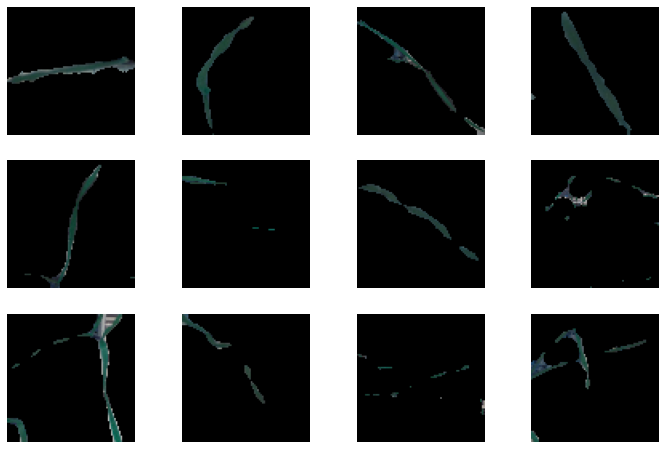

In [7]:
#visulizing the first few images in the dataset
#see if the masks are applied correctly
plt.figure(figsize = (12,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(masked_train_img[i])
    plt.axis('off')
plt.savefig('MaskedTrainImagesSample.png', bbox = 'tight')

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


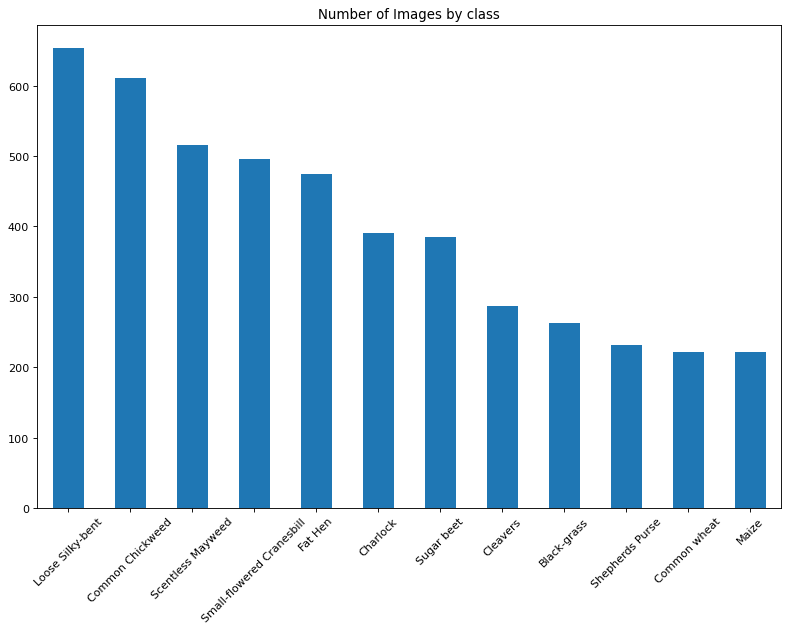

In [8]:
#make classes as categorial and encoding
le = LabelEncoder()
le.fit(train_label[0])
enc_labels = le.transform(train_label[0])
classes = to_categorical(enc_labels)
num_classes = classes.shape[1]
#check
print("Classes: " + str(le.classes_))
print("Number of classes: " + str(num_classes))

# Plot of label types numbers
plt.figure(figsize = (12,8), dpi = 80)
train_label[0].value_counts().plot(kind='bar')
plt.title('Number of Images by class')
plt.xticks(rotation = 45)
plt.savefig('NumberOfImagesByClass.png')

In [8]:
trainX, validX, trainY, validY = train_test_split(masked_train_img, classes, test_size = 0.15, random_state = seed, stratify = classes)

#check splitted size
print(trainX.shape + validX.shape + trainY.shape + validY.shape)

(4037, 80, 80, 3, 713, 80, 80, 3, 4037, 12, 713, 12)


In [9]:
#define a function to plot confusion_matrix

def plot_confusion_matrix(confmat, classes, normalize = False, title = 'Confusion matrix', color = plt.cm.Greens):
    fig = plt.figure(figsize = (10, 10))
    plt.imshow(confmat, interpolation = 'nearest', cmap = color)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(classes))
    plt.xticks(marks, classes, rotation = 90)
    plt.yticks(marks, classes)

    if normalize:
        confmat = confmat.astype('float') / confmat.sum(axis = 1)[:, np.newaxis]

    thresh = confmat.max() / 2.
    for i, j in itertools.product(range(confmat.shape[0]), range(confmat.shape[1])):
        plt.text(j, i, confmat[i, j],
                 horizontalalignment = "center",
                 color = "white" if confmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
###From scratch CNN model

#define 2 generators for image sets with / without augnmentations

#train set
datagen = ImageDataGenerator(rescale = 1.0 / 255)

#augmented train set
aug_datagen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.2, height_shift_range = 0.2,
                 zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, rescale = 1.0 / 255)

datagen.fit(trainX)
aug_datagen.fit(trainX)

In [11]:
###defining from scratch CNN model

np.random.seed(seed)

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5, 5), input_shape = (img_size, img_size, 3), activation = "relu"))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size = (5, 5), activation = "relu"))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 128, kernel_size = (5, 5), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 256, kernel_size = (5, 5), activation = "relu"))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 256, kernel_size = (5, 5), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

opt = optimizers.Adam(lr = 0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 76, 76, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 76, 76, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       2

In [12]:
#fit and train with normal train set
checkpoint = ModelCheckpoint("Data/scratch_1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 30, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

Epoch 1/30
64/64 [==============================] - 275s 4s/step - loss: 2.1993 - accuracy: 0.3686 - val_loss: 443.8850 - val_accuracy: 0.1417

Epoch 00001: val_accuracy improved from -inf to 0.14165, saving model to Data\scratch_1.h5
Epoch 2/30
64/64 [==============================] - 272s 4s/step - loss: 1.4651 - accuracy: 0.5368 - val_loss: 342.0861 - val_accuracy: 0.1360

Epoch 00002: val_accuracy did not improve from 0.14165
Epoch 3/30
64/64 [==============================] - 281s 4s/step - loss: 1.1951 - accuracy: 0.6133 - val_loss: 630.5218 - val_accuracy: 0.1318

Epoch 00003: val_accuracy did not improve from 0.14165
Epoch 4/30
64/64 [==============================] - 283s 4s/step - loss: 1.0926 - accuracy: 0.6455 - val_loss: 804.7618 - val_accuracy: 0.1304

Epoch 00004: val_accuracy did not improve from 0.14165

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
64/64 [==============================] - 284s 4s/step - loss: 0.8882 - accur

KeyboardInterrupt: 

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('scratch_1 performance.png', bbox = 'tight')

In [ ]:
#fit and train with normal train set
checkpoint = ModelCheckpoint("Data/scratch_2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 30, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1 ,2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('scratch_2 performance.png', bbox = 'tight')

In [ ]:
#get prediction for unmasked train set
predY = model.predict(validX)
predY_classes = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

#plot confusion matrix
confusionMTX = confusion_matrix(trueY, predY_classes) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 
plt.savefig('Confusion matrix_scratch.png')

In [ ]:
###VGG16 model

#define 2 generators for image sets with / without augnmentations

#train set
datagen = ImageDataGenerator(preprocessing_function = vgg_preprocess_input)

#augmented train set
aug_datagen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.2, height_shift_range = 0.2,
                 zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, preprocessing_function = vgg_preprocess_input)

datagen.fit(trainX)
aug_datagen.fit(trainX)

In [ ]:
#load pre-trained VGG16 model
vgg_base = VGG16(
    input_shape = (img_size, img_size, 3), 
    weights = 'imagenet', 
    include_top = False 
)

vgg_base.summary()

In [ ]:
#freeze layers
vgg_base.trainable = False

vgg_inputs = keras.Input(shape = (img_size, img_size, 3))
x = vgg_base(vgg_inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
prediction = Dense(num_classes, activation = 'softmax')(x)

opt = optimizers.Adam(lr = 0.001)
model = Model(inputs = vgg_inputs, outputs = prediction)

model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/vgg16_1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 25, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('vgg16_1 performance.png', bbox = 'tight')

In [ ]:
checkpoint = ModelCheckpoint("Data/vgg16_2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 20, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('vgg16_2 performance.png', bbox = 'tight')

In [ ]:
vgg_base.trainable = True

print("Number of layers in the base model: ", len(vgg_base.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune = 14

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base.layers[:fine_tune]:
    layer.trainable =  False
    
model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.0001), metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/vgg16_ft.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist_ft = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = hist.epoch[-1] + 15, initial_epoch = hist.epoch[-1], validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc += hist_ft.history['accuracy']
val_acc += hist_ft.history['val_accuracy']

loss += hist_ft.history['loss']
val_loss += hist_ft.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('vgg16_ft performance.png', bbox = 'tight')

In [ ]:
#get prediction
predY = model.predict(validX)
predY_classes = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

#plot confusion matrix
confusionMTX = confusion_matrix(trueY, predY_classes) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 
plt.savefig('Confusion matrix_vgg16.png', bbox = 'tight')

In [ ]:
###ResNet50 model

#define 2 generators for image sets with / without augnmentations

#train set
datagen = ImageDataGenerator(preprocessing_function = rn50_preprocess_input)

#augmented train set
aug_datagen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.2, height_shift_range = 0.2,
                 zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, preprocessing_function = rn50_preprocess_input)

datagen.fit(trainX)
aug_datagen.fit(trainX)

In [ ]:
#load pre-trained ResNet50 model
resnet_base = ResNet50(
    input_shape = (img_size, img_size, 3), 
    weights = 'imagenet', 
    include_top = False 
)

resnet_base.summary()

In [ ]:
#freeze layers
resnet_base.trainable = False

resnet_inputs = keras.Input(shape = (img_size, img_size, 3))
x = resnet_base(resnet_inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
prediction = Dense(num_classes, activation = 'softmax')(x)

opt = optimizers.Adam(lr = 0.001)
model = Model(inputs = resnet_inputs, outputs = prediction)

model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/resnet50_1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 25, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('resnes50_1 performance.png', bbox = 'tight')

In [ ]:
checkpoint = ModelCheckpoint("Data/resnet50_2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 20, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('resnes50_2 performance.png', bbox = 'tight')

In [ ]:
resnet_base.trainable = True

print("Number of layers in the base model: ", len(resnet_base.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune = 159

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_base.layers[:fine_tune]:
    layer.trainable =  False
    
model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.0001), metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/resnet50_ft.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist_ft = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = hist.epoch[-1] + 10, initial_epoch = hist.epoch[-1], validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc += hist_ft.history['accuracy']
val_acc += hist_ft.history['val_accuracy']

loss += hist_ft.history['loss']
val_loss += hist_ft.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('resnes50_ft performance.png', bbox = 'tight')

In [ ]:
#get prediction
predY = model.predict(validX)
predY_classes = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

#plot confusion matrix
confusionMTX = confusion_matrix(trueY, predY_classes) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 
plt.savefig('Confusion matrix_resnet50.png', bbox = 'tight')

In [ ]:
###InceptionV3 model

#define 2 generators for image sets with / without augnmentations

#train set
datagen = ImageDataGenerator(preprocessing_function = incept_preprocess_input)

#augmented train set
aug_datagen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.2, height_shift_range = 0.2,
                 zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, preprocessing_function = incept_preprocess_input)

datagen.fit(trainX)
aug_datagen.fit(trainX)

In [ ]:
#load pre-trained InceptionV3 model
incept_base = InceptionV3(
    input_shape = (img_size, img_size, 3), 
    weights = 'imagenet', 
    include_top = False 
)

incept_base.summary()

In [ ]:
#freeze layers
incept_base.trainable = False

incept_inputs = keras.Input(shape = (img_size, img_size, 3))
x = incept_base(incept_inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
prediction = Dense(num_classes, activation = 'softmax')(x)

opt = optimizers.Adam(lr = 0.001)
model = Model(inputs = incept_inputs, outputs = prediction)

model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/inceptionv3_1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 25, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('inceptionv3_1 performance.png', bbox = 'tight')

In [ ]:
checkpoint = ModelCheckpoint("Data/inceptionv3_2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 20, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('inceptionv3_2 performance.png', bbox = 'tight')

In [ ]:
incept_base.trainable = True

print("Number of layers in the base model: ", len(incept_base.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune = 261

# Freeze all the layers before the `fine_tune_at` layer
for layer in incept_base.layers[:fine_tune]:
    layer.trainable =  False
    
model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.0001), metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/inceptionv3_ft.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist_ft = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = hist.epoch[-1] + 10, initial_epoch = hist.epoch[-1], validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc += hist_ft.history['accuracy']
val_acc += hist_ft.history['val_accuracy']

loss += hist_ft.history['loss']
val_loss += hist_ft.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('inceptionv3_ft performance.png', bbox = 'tight')

In [ ]:
#get prediction
predY = model.predict(validX)
predY_classes = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

#plot confusion matrix
confusionMTX = confusion_matrix(trueY, predY_classes) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 
plt.savefig('Confusion matrix_inceptionv3.png', bbox = 'tight')

In [ ]:
###Xception model

#define 2 generators for image sets with / without augnmentations

#train set
datagen = ImageDataGenerator(preprocessing_function = xcept_preprocess_input)

#augmented train set
aug_datagen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.2, height_shift_range = 0.2,
                 zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, preprocessing_function = xcept_preprocess_input)

datagen.fit(trainX)
aug_datagen.fit(trainX)

In [ ]:
#load pre-trained Xception model
xcept_base = Xception(
    input_shape = (img_size, img_size, 3), 
    weights = 'imagenet', 
    include_top = False 
)

xcept_base.summary()

In [ ]:
#freeze layers
xcept_base.trainable = False

xcept_inputs = keras.Input(shape = (img_size, img_size, 3))
x = xcept_base(xcept_inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
prediction = Dense(num_classes, activation = 'softmax')(x)

opt = optimizers.Adam(lr = 0.001)
model = Model(inputs = xcept_inputs, outputs = prediction)

model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/xception_1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 25, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('xception_1 performance.png', bbox = 'tight')

In [ ]:
checkpoint = ModelCheckpoint("Data/xception_2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 20, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('xception_2 performance.png', bbox = 'tight')

In [ ]:
xcept_base.trainable = True

print("Number of layers in the base model: ", len(xcept_base.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune = 109

# Freeze all the layers before the `fine_tune_at` layer
for layer in xcept_base.layers[:fine_tune]:
    layer.trainable =  False
    
model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.0001), metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/xception_ft.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 5, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist_ft = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = hist.epoch[-1] + 15, initial_epoch = hist.epoch[-1], validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc += hist_ft.history['accuracy']
val_acc += hist_ft.history['val_accuracy']

loss += hist_ft.history['loss']
val_loss += hist_ft.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('xception_ft performance.png', bbox = 'tight')

In [ ]:
#get prediction
predY = model.predict(validX)
predY_classes = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

#plot confusion matrix
confusionMTX = confusion_matrix(trueY, predY_classes) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 
plt.savefig('Confusion matrix_xception.png', bbox = 'tight')

In [ ]:
###EfficientNetB0 model

#define 2 generators for image sets with / without augnmentations

#train set
datagen = ImageDataGenerator(preprocessing_function = eff_preprocess_input)

#augmented train set
aug_datagen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.2, height_shift_range = 0.2,
                 zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, preprocessing_function = eff_preprocess_input)

datagen.fit(trainX)
aug_datagen.fit(trainX)

In [ ]:
#load pre-trained EfficientNet model
eff_base = EfficientNetB0(
    input_shape = (img_size, img_size, 3), 
    weights = 'imagenet', 
    include_top = False 
)

eff_base.summary()

In [ ]:
#freeze layers
eff_base.trainable = False

eff_inputs = keras.Input(shape = (img_size, img_size, 3))
x = eff_base(eff_inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
prediction = Dense(num_classes, activation = 'softmax')(x)

opt = optimizers.Adam(lr = 0.001)
model = Model(inputs = eff_inputs, outputs = prediction)

model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/efficientnetb0_1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 25, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('efficientnetb0_1 performance.png', bbox = 'tight')

In [ ]:
checkpoint = ModelCheckpoint("Data/efficientnetb0_2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = 20, validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('efficientnetb0_2 performance.png', bbox = 'tight')

In [ ]:
eff_base.trainable = True

print("Number of layers in the base model: ", len(eff_base.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in eff_base.layers[:fine_tune]:
    layer.trainable =  False
    
model.summary()

In [ ]:
model.compile (loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.0001), metrics = ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("Data/efficientnetb0_ft.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 5, verbose = 1, mode = 'max')
lr_reduc = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

hist_ft = model.fit_generator(aug_datagen.flow(trainX, trainY, batch_size = batch_size), epochs = hist.epoch[-1] + 15, initial_epoch = hist.epoch[-1], validation_data = (validX, validY), callbacks = [checkpoint, early, lr_reduc])

In [ ]:
#plot model performance by accuracy and loss

acc += hist_ft.history['accuracy']
val_acc += hist_ft.history['val_accuracy']

loss += hist_ft.history['loss']
val_loss += hist_ft.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.axvline(x = hist.epoch[-1], color = 'g', label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('efficientnetb0_ft performance.png', bbox = 'tight')

In [ ]:
#get prediction
predY = model.predict(validX)
predY_classes = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

#plot confusion matrix
confusionMTX = confusion_matrix(trueY, predY_classes) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 
plt.savefig('Confusion matrix_efficientnetb0.png', bbox = 'tight')

In [ ]:
#predict test images with EfficientNetB0 model and write to submission.csv 

#reading the test set from directory
test_path = 'Data/test/*.png' 
files = glob(test_path)

test_img = []
file_name = []

#read image files and store file name
for img in files:
    test_img.append(cv2.resize(cv2.imread(img), (img_size, img_size)))  #resize and append
    file_name.append(os.path.split(img)[1])  #Get image file name

test_img = np.asarray(test_img)  #Test images set

print(test_img.shape)
file_name

In [ ]:
plt.figure(figsize = (12,8), dpi = 80)
#visulizing the first few images in the dataset
for i in range(12):
    plt.subplot(3, 4, i + 1)
    #cv2 read in BGR, show as in RGB
    plt.imshow(cv2.cvtColor(test_img[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
plt.savefig('TestImagesSample.png', bbox = 'tight')

In [ ]:
#Create masks 

masked_test_img = []
#mask every img in train_img and store in masked_train_img
show_example = True
for img in test_img:
    #Gaussian blur
    blur_img = cv2.GaussianBlur(img, (5, 5), 0)   
    
    #HSV mask
    hsv_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)   
    lower_green = (25, 30, 40)
    upper_green = (85, 255, 255)
    mask = cv2.inRange(hsv_img, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    #Boolean mask
    boo_mask = mask > 0  
    
    #Apply mask
    tmp = np.zeros_like(img, np.uint8)  #Empty image
    tmp[boo_mask] = img[boo_mask]  
    
    masked_test_img.append(tmp)  
    
    #Show first masked image
    if show_example:
        plt.figure(figsize = (9, 6))
        plt.subplot(2, 3, 1)
        plt.axis('off')
        plt.imshow(img)  #original image
        plt.subplot(2, 3, 2)
        plt.axis('off')
        plt.imshow(blur_img)  #G-Blurred image
        plt.subplot(2, 3, 3)
        plt.axis('off')
        plt.imshow(hsv_img)  #image in HSV
        plt.subplot(2, 3, 4)
        plt.axis('off')
        plt.imshow(mask)  #mask image
        plt.subplot(2, 3, 5)
        plt.axis('off')
        plt.imshow(boo_mask)  #boolean mask
        plt.subplot(2, 3, 6)
        plt.axis('off')
        plt.imshow(tmp)  #masked image
        plt.savefig('ImageAndMask.png', bbox = 'tight')
        show_example = False

masked_test_img = np.asarray(masked_test_img)

In [ ]:
#visulizing the first few images in the dataset
#see if the masks are applied correctly
plt.figure(figsize = (12,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(masked_test_img[i])
    plt.axis('off')
plt.savefig('MaskedTestImagesSample.png', bbox = 'tight')

In [ ]:
pred = model.predict(masked_test_img)
# Write result to csv
predNum = np.argmax(pred, axis = 1)
predClass = le.classes_[predNum]

result = {'file': file_name, 'species': predClass}
result = pd.DataFrame(result)
result.to_csv("Submission.csv", index = False)